# Depedency code

In [1]:
import imp
import os
import sys
import numpy as np
import glob
import cmdbench

fp, pathname, description = imp.find_module('benchmark', ['../lib'])
benchmark = imp.load_module('benchmark', fp, pathname, description)

os.environ['BIGSI_CONFIG'] = 'berkleydb.yaml'

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

# Software versions

In [2]:
!mccortex 31 2>&1 | grep version

version: mccortex=v0.0.3-610-g400c0e3 zlib=1.2.11 htslib=1.8-17-g699ed53 ASSERTS=ON hash=Lookup3 CHECKS=ON k=3..31


In [3]:
!bigsi --version | grep bigsi-v

bigsi-v0.3.1


# Benchmarking

## Input data and constants

In [4]:
input_dir = 'input-small'

input_files_1 = [os.path.basename(f) for f in glob.glob(f'{input_dir}/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
input_samples.sort()
print(input_samples)

nproc=4
kmer=31

bigsi_dir = 'bigsi-data'
#sample_sizes = [1,10,20,30,40,50,60,70,80]
sample_sizes = [1, 10]

['2014C-3598', '2014C-3599', '2014C-3600', '2014C-3655', '2014C-3656', '2014C-3840', '2014C-3850', '2014C-3857', '2014C-3907', '2014D-0067', '2014D-0068', '2014D-0070', '2014D-0189', 'CFSAN000189', 'CFSAN000191', 'CFSAN000211', 'CFSAN000212', 'CFSAN000228', 'CFSAN000661', 'CFSAN000669', 'CFSAN000700', 'CFSAN000752', 'CFSAN000753', 'CFSAN000951', 'CFSAN000952', 'CFSAN000954', 'CFSAN000958', 'CFSAN000960', 'CFSAN000961', 'CFSAN000963', 'CFSAN000968', 'CFSAN000970', 'CFSAN001112', 'CFSAN001115', 'CFSAN001118', 'CFSAN001140', 'CFSAN002349', 'CFSAN023463', 'CFSAN023464', 'CFSAN023465', 'CFSAN023466', 'CFSAN023467', 'CFSAN023468', 'CFSAN023469', 'CFSAN023470', 'CFSAN023471', 'D5663', 'D7316', 'D7319', 'D7320', 'D7321', 'D7322', 'D7323', 'D7324', 'D7327', 'D7328', 'D7329', 'D7330', 'D7331', 'D7333', 'D7334', 'MOD1_LS1000', 'MOD1_LS1003', 'MOD1_LS1004', 'MOD1_LS1005', 'MOD1_LS1006', 'MOD1_LS1008', 'MOD1_LS1009', 'MOD1_LS1010', 'MOD1_LS1011', 'MOD1_LS982', 'MOD1_LS985', 'MOD1_LS989', 'MOD1_LS99

## Benchmark functions

In [5]:
def reset_func():
    # Delete indexed data
    os.system("bigsi delete")

    # Delete all saved bigsi data
    benchmark.clean_if_exists(bigsi_dir)
    benchmark.clean_if_exists("test-berkeley.db")
    
def sampling_func(input_size):
    return input_samples[:input_size]

mccortex_command = {
    "command": f"mccortex 31 build --nkmers 100000000 --threads 1 --kmer {kmer} --mem 20G" \
        + f" --sample % --seq2 {input_dir}/%_1.fastq.gz:{input_dir}/%_2.fastq.gz {bigsi_dir}/%.ctx",
    "parallel_args": f"-j {nproc} -I%"
}

bigsi_bloom_command = {
    "command": f"bigsi bloom -c berkleydb.yaml {bigsi_dir}/%.ctx {bigsi_dir}/%.bloom",
    "parallel_args": f"-j {nproc} -I%"
}

bigsi_build_command = {
    "command": lambda sample_files: "bigsi build -c berkleydb.yaml" + " -s " + (" -s ").join(sample_files) \
        + " " + " ".join(list(map(lambda sample_file: f"{bigsi_dir}/%s.bloom" % sample_file, sample_files))),
}

query_repeat_count = 2
query_sequence = "GAAGAAGATGGTGTACGCGGTGCGCGCCGCTATCTCGACCACCTTAAAATGGAATATGCCTTCTGGATGGACG"

query_command = {
    "command": "bigsi search % --config berkleydb.yaml -t 0.8",
    "parallel_argfiles": [query_sequence] * query_repeat_count,
    "parallel_args": "-j 1 -I%"
}

## Benchmark

In [6]:
multibench_results, debug_str = benchmark.multibench.multi_cmdbench({
        "index": [mccortex_command, bigsi_bloom_command, bigsi_build_command],
        "query": [query_command]
    },
    reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results=benchmark.benchmark_list_to_results, active_output_print = True
)

>>>>>>>>>>>>>
parallel -j 4 -I% mccortex 31 build --nkmers 100000000 --threads 1 --kmer 31 --mem 20G --sample % --seq2 input-small/%_1.fastq.gz:input-small/%_2.fastq.gz bigsi-data/%.ctx ::: 2014C-3598

STDOUT: 
-------------
STDERR: [18 Sep 2020 10:01:20-vAW][cmd] /home/CSCScience.ca/apetkau/miniconda3/envs/thesis-benchmarking/bin/mccortex31 build --nkmers 100000000 --threads 1 --kmer 31 --mem 20G --sample 2014C-3598 --seq2 input-small/2014C-3598_1.fastq.gz:input-small/2014C-3598_2.fastq.gz bigsi-data/2014C-3598.ctx
[18 Sep 2020 10:01:20-vAW][cwd] /home/CSCScience.ca/apetkau/workspace/thesis-benchmarking/bigsi
[18 Sep 2020 10:01:20-vAW][version] mccortex=v0.0.3-610-g400c0e3 zlib=1.2.11 htslib=1.8-17-g699ed53 ASSERTS=ON hash=Lookup3 CHECKS=ON k=3..31
[18 Sep 2020 10:01:20-vAW] Saving graph to: bigsi-data/2014C-3598.ctx
[18 Sep 2020 10:01:20-vAW][sample] 0: 2014C-3598
[18 Sep 2020 10:01:20-vAW][task] input-small/2014C-3598_1.fastq.gz; FASTQ offset: auto-detect, threshold: off; cut homopo

# Save and reload results

In [7]:
save_path = "bigsi-results.txt"

samples_per_sample_size = []
for sample_size in sample_sizes:
        samples_per_sample_size.append(input_samples[:sample_size])

benchmark.multibench.save_multibench_results(multibench_results, samples_per_sample_size, save_path)
multibench_results, samples_per_sample_size = benchmark.multibench.read_multibench_results(save_path)
print(multibench_results)

[{'index': {'runtime': 292.64, 'memory': 1190371328.0, 'disk_read': 153144628219.0, 'disk_write': 153216946906.0}, 'query': {'runtime': 1.46, 'memory': 85745664.0, 'disk_read': 20089031.0, 'disk_write': 698627.0}}, {'index': {'runtime': 314.57, 'memory': 4237901824.0, 'disk_read': 153240640323.0, 'disk_write': 153293432783.0}, 'query': {'runtime': 1.42, 'memory': 85876736.0, 'disk_read': 20108595.0, 'disk_write': 698599.0}}]


# Plot

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5

[{'runtime': 292.64, 'memory': 1190371328.0, 'disk_read': 153144628219.0, 'disk_write': 153216946906.0}, {'runtime': 314.57, 'memory': 4237901824.0, 'disk_read': 153240640323.0, 'disk_write': 153293432783.0}]


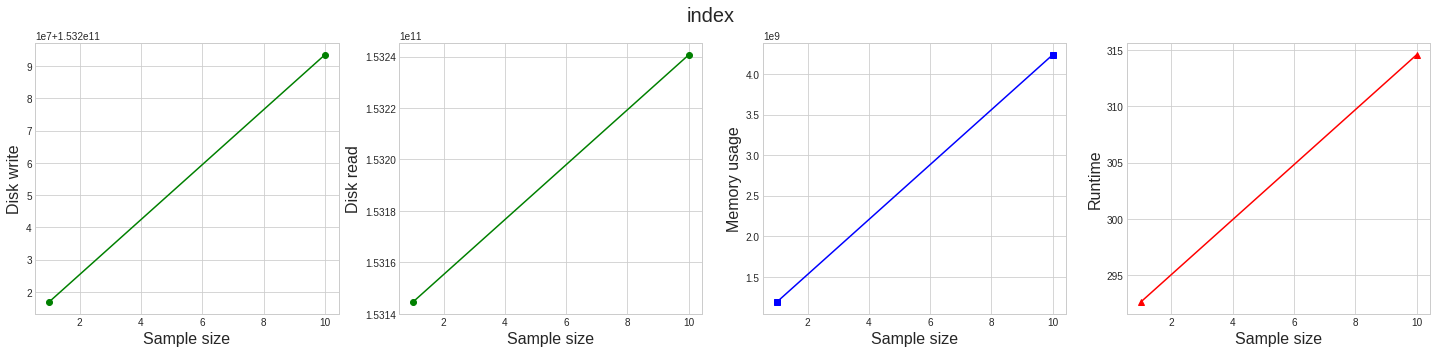

In [9]:
# Indexing Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "index")

[{'runtime': 1.46, 'memory': 85745664.0, 'disk_read': 20089031.0, 'disk_write': 698627.0}, {'runtime': 1.42, 'memory': 85876736.0, 'disk_read': 20108595.0, 'disk_write': 698599.0}]


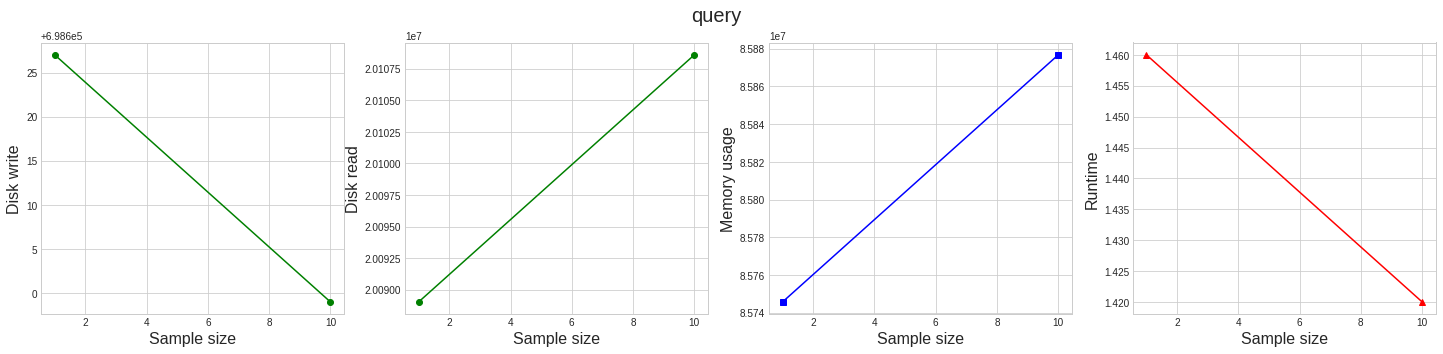

In [10]:
# Querying Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "query")